<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [1]:
!pip install pysynphot --quiet
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install git+https://github.com/astrofrog/sedfitter@master --quiet

     |████████████████████████████████| 10.8 MB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


#**Imports**

In [2]:
import pysynphot as S

/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
!export PYSYN_CDBS=/my/local/dir/trds/

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
import pysynphot as S
import sedfitter as sed

import mastcasjobs
from scipy.optimize import minimize_scalar,minimize

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

# **GitHub**

In [5]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 631, done.
remote: Counting objects: 100% (256/256), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 631 (delta 140), reused 4 (delta 2), pack-reused 375
Receiving objects: 100% (631/631), 65.55 MiB | 19.49 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [6]:
cd INSIST/data

/content/INSIST/data


In [7]:
!cp -a plot.py /usr/local/lib/python3.7/dist-packages/sedfitter

# **Data**

## **CasJobs Script**

In [ ]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 28) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **M 31 Test**

In [8]:
df_M31 = Table.read('M31_crossmatch.fits')
t=[]
for i in df_M31['Filter']:
  t.append(i.split()[0])

df_M31 = df_M31.to_pandas().rename(columns = {'raStack':'ra','decStack':'dec'})

df_M31['Filter'] = t
df_M31

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation
0,FUVCaF2,11.0050,41.372601,22.556999,20.156000,0.104,"b'1, 2 '",3,157640110050187706,11.005001,41.372588,20.251699,0.016611,20.385599,0.022176,20.485701,0.024243,20.354401,0.062501,20.303400,0.096491,0.369685,0.043593
1,FUVCaF2,10.8824,41.446201,22.525999,20.125000,0.102,"b'1, 2 '",3,157730108824256022,10.882441,41.446148,21.872499,0.063081,22.364799,0.120779,21.684299,0.077272,21.827299,0.198476,22.543200,0.806140,0.012833,0.222159
2,FUVCaF2,11.0068,41.368599,22.677999,20.277000,0.113,"b'1, 2 '",3,157640110067852870,11.006835,41.368553,20.694000,0.022622,20.539499,0.021383,20.524500,0.028266,20.584499,0.054087,20.421499,0.097740,0.040125,0.192727
3,FUVCaF2,10.9376,41.415699,22.198000,19.797001,0.093,"b'1, 2 '",3,157690109375969504,10.937593,41.415661,20.555000,0.022185,20.558201,0.025005,20.419001,0.022528,20.097500,0.036679,20.198799,0.090087,0.012375,0.137362
4,FUVCaF2,10.9585,41.384899,23.364000,20.962999,0.161,"b'1, 2 '",3,157660109585222564,10.958540,41.385006,21.745300,0.072161,21.099100,0.037309,20.879101,0.032354,20.508499,0.050840,20.969400,0.200653,0.075208,0.400405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7598,NUVN2,11.0671,41.070000,19.358999,17.858999,0.105,b'7 ',0,157280110671684643,11.067159,41.070006,14.721900,0.000689,14.072800,0.000365,14.068700,0.000323,13.782600,0.000537,13.736200,0.000622,0.988167,0.162084
7599,NUVN2,11.0833,41.296700,19.736000,18.236000,0.138,b'7 ',9,157550110833086707,11.083265,41.296760,18.607800,0.005139,18.419201,0.003868,18.445499,0.004408,18.419901,0.011739,18.325100,0.016152,0.003542,0.238476
7600,NUVN2,11.0289,41.079399,18.735001,17.235001,0.081,b'7 ',0,157290110289975982,11.029001,41.079458,15.802300,0.000937,15.466000,0.000743,15.331300,0.000581,15.224300,0.001314,15.386800,0.001587,0.982369,0.346155
7601,NUVN2,11.1346,41.028301,19.311001,17.811001,0.103,b'7 ',0,157230111346554603,11.134657,41.028309,15.547000,0.000800,15.182300,0.000643,14.996400,0.000561,14.892900,0.001008,14.937400,0.001074,0.969958,0.159610


## **Query**

In [ ]:
try:
  df = casjobs('M 67', cols = {'raStack':'ra','decStack':'dec'}).df
except:
  df = pd.read_csv('M67_PS1.csv')
  df =  df.rename(columns = {'raStack':'ra','decStack':'dec'})

In [ ]:
df_star = df[df['ps_score']>0.5].copy()

In [ ]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score
2,121971328494717854,132.849460,11.647811,14.869100,0.000533,14.360300,0.000274,14.238800,0.000320,14.228000,0.000519,14.180500,0.000877,0.997500
3,121981327802535449,132.780255,11.654201,22.408501,0.070046,21.075701,0.020825,19.894899,0.010747,19.387800,0.012878,19.222099,0.028750,0.967161
7,121981328054472261,132.805456,11.651512,20.532900,0.016547,20.011999,0.012918,19.655001,0.009876,19.598499,0.015401,19.531300,0.032895,0.973104
8,121981328218108430,132.821806,11.656615,21.308001,0.035670,20.095501,0.021422,18.960800,0.006396,18.470501,0.006572,18.143700,0.010728,0.987833
10,121981328277113751,132.827729,11.652668,21.941999,0.059630,20.682800,0.015879,19.333900,0.007499,18.809700,0.007518,18.456301,0.013550,0.969271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,122361328754558683,132.875457,11.973499,14.265200,0.000371,13.934200,0.000273,13.864500,0.000378,13.834500,0.000453,13.799800,0.000760,0.998333
1826,122361328754558683,132.875457,11.973499,14.207000,0.000346,13.959600,0.000281,13.872400,0.000384,13.830000,0.000452,13.809400,0.000760,0.998333
1827,122361328818090634,132.881819,11.966787,16.971201,0.001754,16.576300,0.001196,16.217600,0.002029,16.417000,0.002133,16.384300,0.003584,0.997500
1828,122371328134963003,132.813494,11.977090,14.216200,0.000410,13.841900,0.000236,13.694600,0.000315,13.673500,0.000408,13.638000,0.000744,0.994167


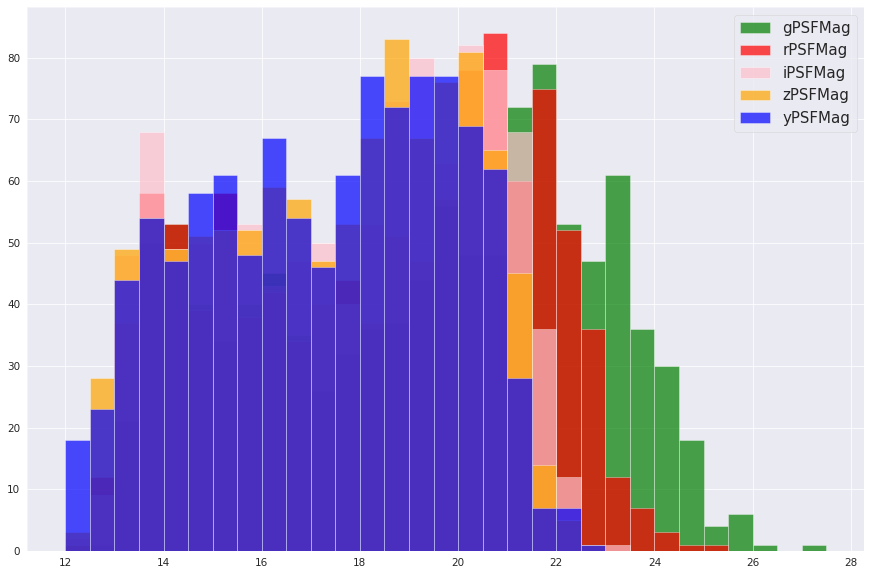

In [ ]:
bin_min = 12
bin_max = 28
step  = 0.5
bins = np.arange(bin_min,bin_max, step)

plt.hist(df_star['gPSFMag'],bins=bins,alpha=0.7,color = 'green')
plt.hist(df_star['rPSFMag'],bins=bins,alpha=0.7,color = 'red')
plt.hist(df_star['iPSFMag'],bins=bins,alpha=0.7,color = 'pink')
plt.hist(df_star['zPSFMag'],bins=bins,alpha=0.7,color = 'orange')
plt.hist(df_star['yPSFMag'],bins=bins,alpha=0.7,color = 'blue');
plt.legend(['gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag',])

# **Synthetic Spectra**

## **Model**

In [9]:
if os.path.exists('models_kurucz'):
  os.system('rm -r models_kurucz')

In [10]:
!curl -o models ftp://ftp.astro.wisc.edu/outgoing/tom/model_packages/models_kurucz_05sep11.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.0M  100 83.0M    0     0  7093k      0  0:00:11  0:00:11 --:--:-- 11.5M


In [11]:
!tar -xzf models

In [12]:
!rm models

## **Filters**

Initializing filter parameters using response curves

In [13]:
filter_dict = {'PS1g'    : [4881.47, 'PAN-STARRS_PS1.g.dat' ],
               'PS1r'    : [6198.41, 'PAN-STARRS_PS1.r.dat' ],
               'PS1i'    : [7549.34, 'PAN-STARRS_PS1.i.dat' ],
               'PS1z'    : [8701.37, 'PAN-STARRS_PS1.z.dat' ],
               'PS1y'    : [9509.80,'PAN-STARRS_PS1.y.dat' ],
               'UVIT_NUV': [2792.56,'Astrosat_UVIT.N279N.dat'],
               'UVIT_FUV': [1506.00,'Astrosat_UVIT.F148Wa.dat']}

model_dir = 'models_kurucz'

filter_list = []
for filter in filter_dict.keys():

  filt_obj = sed.filter.Filter()
  filt_obj.name = filter
  filt_obj.central_wavelength = (filter_dict[filter][0]*u.angstrom).to(u.micron)
  filt_obj_wl, filt_obj_rsr = np.loadtxt(filter_dict[filter][1], usecols=(0, 1), unpack=True)
  filt_obj.nu = 3.0e18 * u.Hz / np.flip(filt_obj_wl)
  filt_obj.response = filt_obj_rsr/filt_obj_rsr.max() 
  filt_obj.normalize()
  filter_list.append(filt_obj)

Convolving filters with models

In [14]:
sed.convolve.convolve_model_dir(model_dir, filter_list)

INFO: 3808 SEDs found in models_kurucz [sedfitter.convolve.convolve]
INFO: Rebinning filters [sedfitter.convolve.convolve]


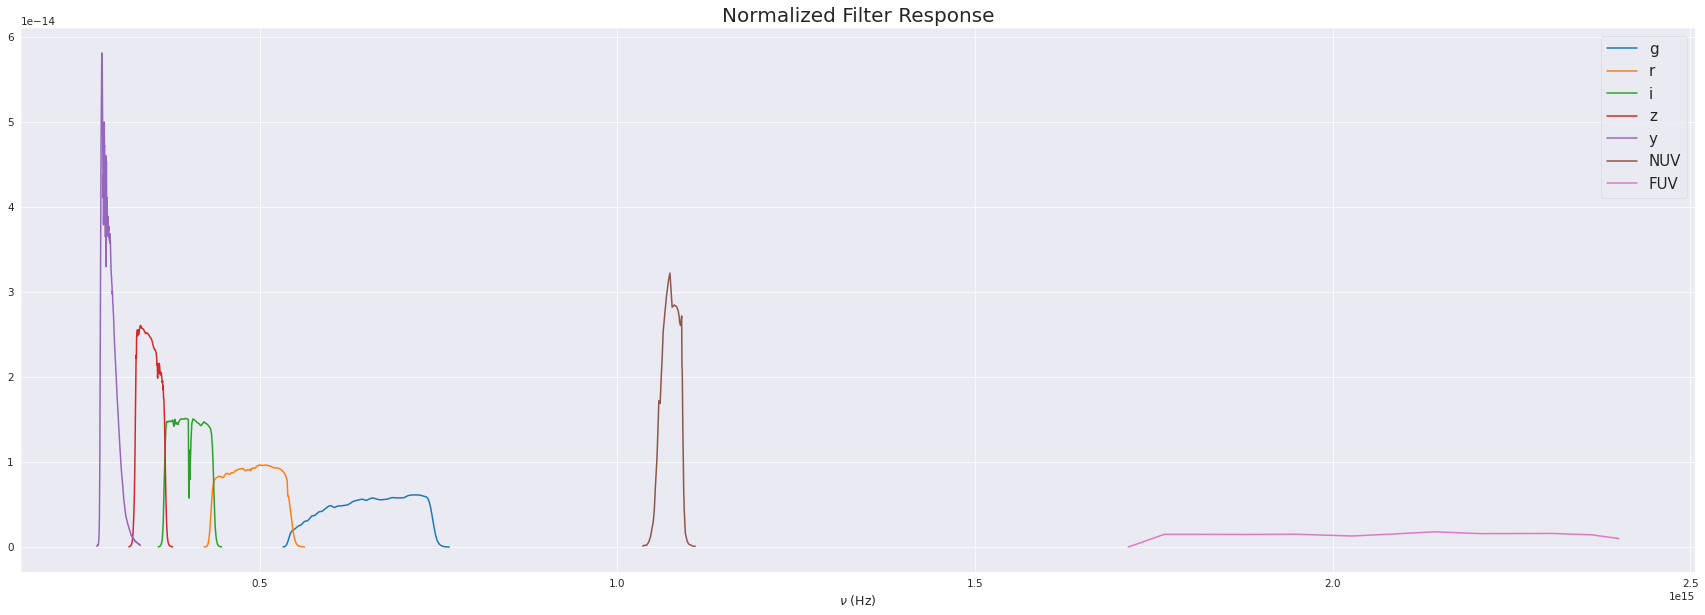

In [15]:
plt.figure(figsize = (30,10))
for filter in filter_list:
  plt.plot(filter.nu,filter.response)

plt.xlabel(r'$\nu$ (Hz)')
plt.title('Normalized Filter Response',size=20)
plt.legend(['g','r','i','z','y' ,'NUV','FUV'])

## **SED Fitting**

### **SED Fitter**

#### **Data**

In [16]:
df_star = df_M31[df_M31['Filter']=='NUVN2'][:1]
df_star

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation
6104,NUVN2,10.8409,41.4216,18.524,17.024,0.055,"b'1, 2 '",0,157700108409766519,10.840969,41.421568,15.1915,0.000671,14.8708,0.000536,14.8466,0.000476,14.8092,0.001326,14.7037,0.001396,0.940364,0.218805


In [17]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

In [18]:
df_star['g_flag'] = 1
df_star['i_flag'] = 1
df_star['r_flag'] = 1
df_star['z_flag'] = 1
df_star['y_flag'] = 1

In [19]:
df_star = df_star.drop_duplicates('objid')
df_star

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,g_flag,i_flag,r_flag,z_flag,y_flag
6104,NUVN2,10.8409,41.4216,18.524,17.024,0.055,"b'1, 2 '",0,157700108409766519,10.840969,41.421568,15.1915,0.000671,14.8708,0.000536,14.8466,0.000476,14.8092,0.001326,14.7037,0.001396,0.940364,0.218805,3.043872,0.001874,4.089839,0.002011,4.182023,0.001826,4.328587,0.005266,4.770306,0.006109,1,1,1,1,1


In [20]:
filters = ['ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ]

In [21]:
df_star[filters]

,ABmag,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag
6104,18.524,15.1915,14.8708,14.8466,14.8092,14.7037


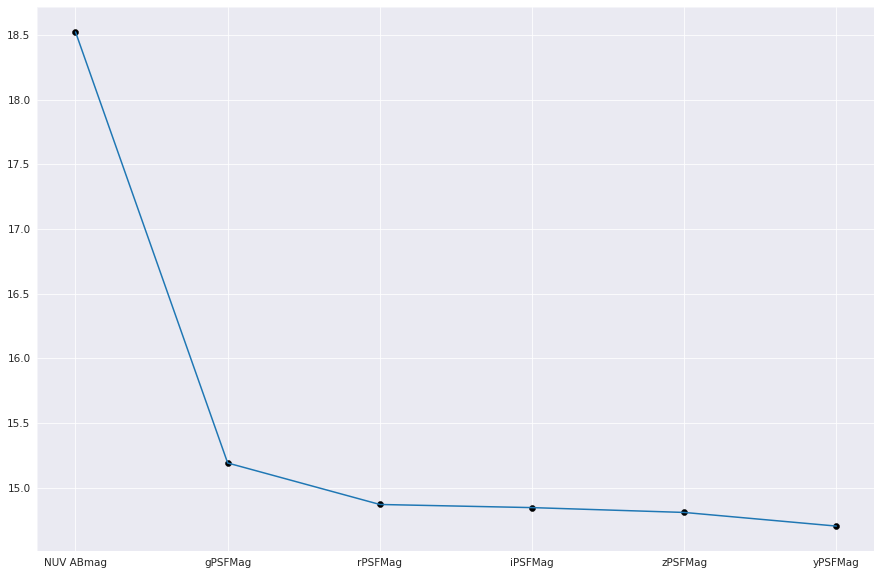

In [22]:
for i,flux in df_star[filters].iterrows():
  plt.scatter(['NUV ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ],flux,marker = 'o', color = 'black')
  plt.plot(['NUV ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag', ],flux)
  break

In [23]:
df_out = df_star[['objid', 'ra', 'dec', 'g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

In [24]:
df_out 

,objid,ra,dec,g_flag,i_flag,r_flag,z_flag,y_flag,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err
6104,157700108409766519,10.840969,41.421568,1,1,1,1,1,3.043872,0.001874,4.089839,0.002011,4.182023,0.001826,4.328587,0.005266,4.770306,0.006109


In [25]:
df_out.to_csv('data_input.dat', sep = " ",index=False, header=False)

#### **Fit**

In [26]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [3., 3., 3., 3., 3.] * u.arcsec

# Run the fitting
d = sed.fit('data_input.dat', filters, apertures, model_dir, 'output.fitinfo', extinction_law=extinction, distance_range=[0.01, 2.] * u.Mpc,av_range=[0., 40.],output_convolved=True)

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  Kurucz stellar photospheres
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading models_kurucz/convolved/PS1g.fits
   Reading models_kurucz/convolved/PS1r.fits
   Reading models_kurucz/convolved/PS1i.fits
   Reading models_kurucz/convolved/PS1z.fits
   Reading models_kurucz/convolved/PS1y.fits
 ------------------------------------------------------------
  => Fitting parameters
 ------------------------------------------------------------

   Minimum A_V      :     0.000 mag
   Maximum A_V      :    40.000 mag
   Minimum distance :     0.010 Mpc
   Maximum distance :     2.000 Mpc

 ------------------------------------------------------------
  => Output parameters
 ----

In [ ]:
from sedfitter import plot
plot('output.fitinfo', 'plots_seds', select_format=('F', 3), show_convolved=True,format='png')


Extracting fitting parameters from SED Fitter output

In [33]:
fin = sed.FitInfoFile('output.fitinfo', 'r')
modpar = sed.utils.parfile.read("%s/models.conf" % fin.meta.model_dir, 'conf')

f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)

nuv_filter = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1)
fuv_filter = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1)

flux     = []
flux_err = []
chi2     = []
Avs      = []
for info in fin:
  Avs.append([info.av]*7)
  model_name = info.model_name[0]
  chi2.append(info.chi2[0])

  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  NUV = [nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  FUV = [fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([FUV[0]*sc, NUV[0]*sc, g[0]*sc, r[0]*sc, i[0]*sc, z[0]*sc, y[0]*sc])

  flux_err.append([FUV[1], NUV[1], g[1], r[1], i[1], z[1], y[1]])

  

flux = np.array(flux)

Avs = np.array(Avs)

flux_err = np.array(flux_err)

In [34]:
info.model_name[0] == 'kt06500g+0.5z+0.5'

True

In [35]:
tab_star = Table.from_pandas(df_star)

tab_star['model_flux']     = flux
tab_star['model_flux_err'] = flux_err
tab_star['Av']             = Avs
tab_star['model_mag']      = -2.5*np.log10(tab_star['model_flux']*pow(10,-0.4*tab_star['Av'])/3631e3) 
tab_star['model_mag_err']  =  1.09*tab_star['model_flux_err']/tab_star['model_mag'] 
tab_star['chi2'] =chi2

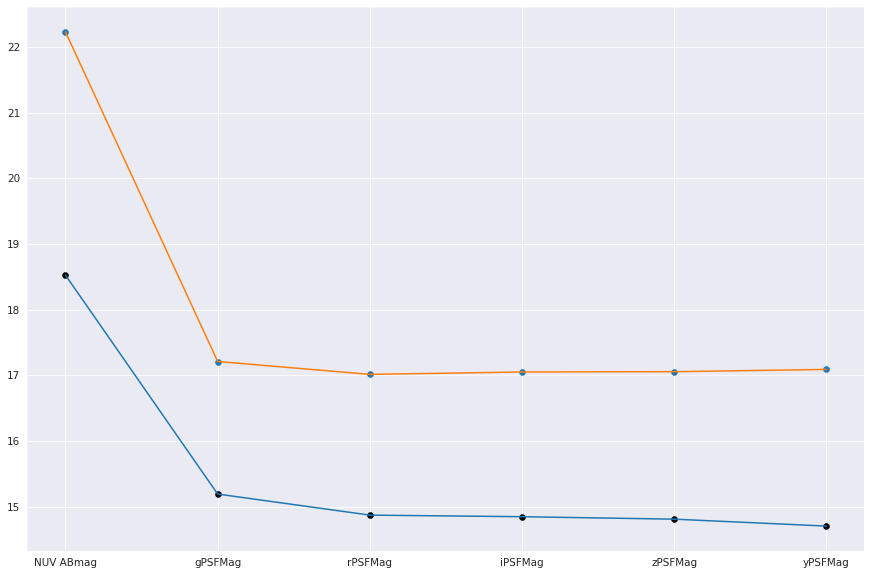

In [36]:
filters = ['ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

x = ['NUV ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']
for i,fl in df_star[filters].iterrows():
  plt.scatter(x,fl,marker = 'o', color = 'black')
  plt.plot(x,fl)
  break
  
plt.plot(x,tab_star['model_mag'].value[0][1:])
plt.scatter(x,tab_star['model_mag'].value[0][1:])

Text(0.5, 1.0, 'SED Fitter')

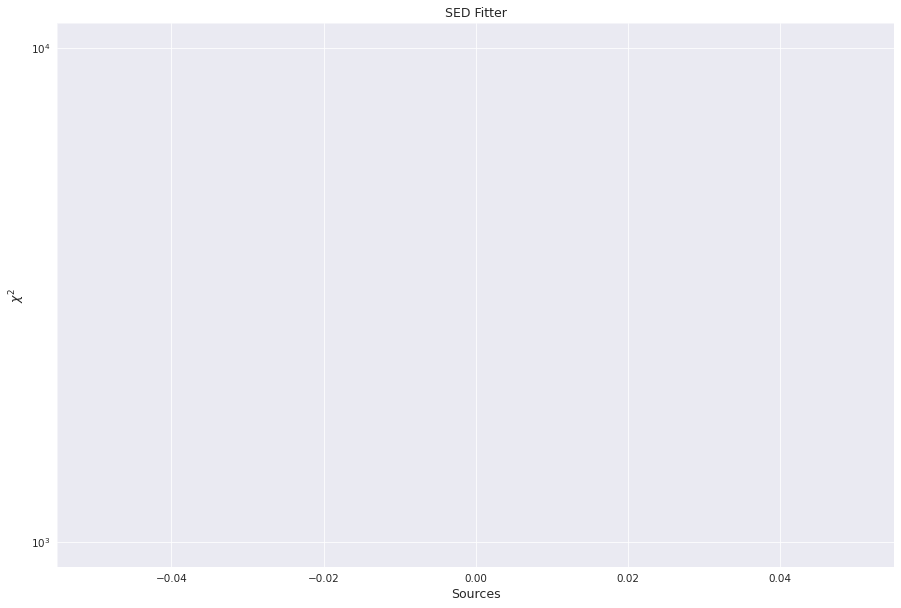

In [39]:
plt.plot(chi2)
plt.yscale('log')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Sources')
plt.title('SED Fitter')

### **SED Fitting Routine**

EMCEE : Bayesian. 

In [ ]:
74 EMCEE

#### **Data**

In [40]:
df_star = df_star = df_M31[df_M31['Filter']=='NUVN2'][:1]
df_star.head(5)

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation
6104,NUVN2,10.8409,41.4216,18.524,17.024,0.055,"b'1, 2 '",0,157700108409766519,10.840969,41.421568,15.1915,0.000671,14.8708,0.000536,14.8466,0.000476,14.8092,0.001326,14.7037,0.001396,0.940364,0.218805


In [41]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

#### **Fit**

In [42]:
def chi2_func(params,flux,model_flux,flux_err,ext):
  Md, av = params
  chi = (flux - Md*model_flux*pow(10,-0.4*av*ext))/flux_err
  return chi@chi

$\chi^2 =\dfrac{1}{N - n_p}\sum\limits_{i=1}^j\left(\dfrac{Y_{i,o} -M_d \times Y_{i,M}\times10^{-0.4\times ext_i\times A_v}}{\sigma_{i,o}}\right)^2$

In [43]:
# Convolved Filters
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]
ext = np.array([1.18, 0.881, 0.667, 0.534,0.457])
chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():
  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux', 'yPSFFlux']].values
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err', 'yPSFFlux_err']].values

  for j,model_flux in enumerate(zip(f1,f2,f3,f4,f5)):
    model_flux = np.array(model_flux)

    params = minimize(chi2_func,x0 = (1e-2,0.5),bounds=([0,np.inf],[0,np.inf]),args=(flux,model_flux,flux_err,ext)).x
    Md, Av = params
    chi2   = chi2_func(params,flux,model_flux,flux_err,ext)
    chi_set.append([row['objid'],model_name[j],Md,Av,chi2])

In [44]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','Av','chi2'])

In [45]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [46]:
df_chi_min

,objid,model_name,Md,Av,chi2
1050,157700108409766519,kt06500g+0.5z+0.5,0.6383,0.386339,5032.017178


In [47]:
'kt06500g+0.5z+0.5'

'kt06500g+0.5z+0.5'

In [48]:
len(df_chi_min.model_name.unique())

1

In [98]:
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)

nuv_filter = Table.read('models_kurucz/convolved/UVIT_NUV.fits',hdu=1)
fuv_filter = Table.read('models_kurucz/convolved/UVIT_FUV.fits',hdu=1)

flux     = []
flux_err = []
Avs      = []
Mds      = []
ext = np.array([2.67, 1.95,1.18, 0.881, 0.667, 0.534,0.457])
for i,row in df_chi_min.iterrows():
  model_name = row['model_name']
  Md = row['Md'] 
  Av = row['Av']
  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  NUV = [nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , nuv_filter[nuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  FUV = [fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , fuv_filter[fuv_filter['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([Md*FUV[0]*pow(10,-0.4*ext[0]*Av), Md*NUV[0]*pow(10,-0.4*ext[1]*Av), Md*g[0]*pow(10,-0.4*ext[2]*Av), Md*r[0]*pow(10,-0.4*ext[3]*Av), Md*i[0]*pow(10,-0.4*ext[4]*Av), Md*z[0]*pow(10,-0.4*ext[5]*Av), Md*y[0]*pow(10,-0.4*ext[6]*Av)])
  flux_err.append([FUV[1], NUV[1], g[1], r[1], i[1], z[1], y[1]])

  Avs.append(row['Av'])
  Mds.append(row['Md'])

flux = np.array(flux)

flux_err = np.array(flux_err)

Avs = np.array(Avs)

Mds = np.array(Mds)

In [95]:
tab_star = Table.from_pandas(df_star)
tab_star['model_flux'] =  flux
tab_star['model_mag']  =  -2.5*np.log10(flux/3631000)

In [96]:
df_star

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err
6104,NUVN2,10.8409,41.4216,18.524,17.024,0.055,"b'1, 2 '",0,157700108409766519,10.840969,41.421568,15.1915,0.000671,14.8708,0.000536,14.8466,0.000476,14.8092,0.001326,14.7037,0.001396,0.940364,0.218805,3.043872,0.001874,4.089839,0.002011,4.182023,0.001826,4.328587,0.005266,4.770306,0.006109


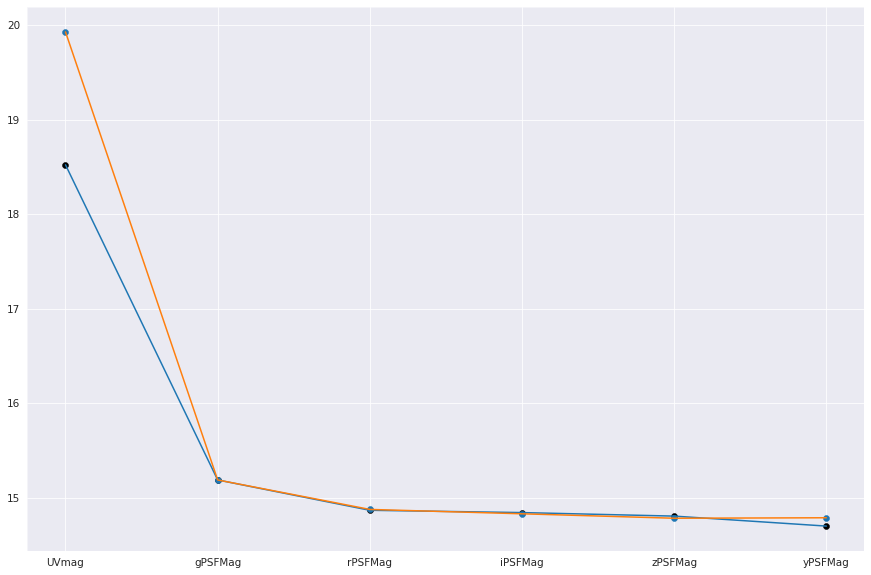

In [97]:
filters = ['ABmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']

x = ['UVmag','gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag']
for i,fl in df_star[filters].iterrows():
  plt.scatter(x,fl,marker = 'o', color = 'black')
  plt.plot(x,fl)
  break
plt.plot(x,tab_star['model_mag'].value[0][[1,2,3,4,5,6]])

plt.scatter(x,tab_star['model_mag'].value[0][[1,2,3,4,5,6]])

In [93]:
model_name = df_chi_min['model_name'].values[0]
model_name

'kt06500g+0.5z+0.5'

In [ ]:
model_sed = Table.read(f'models_kurucz/seds/{model_name}_sed.fits.gz',hdu=1)

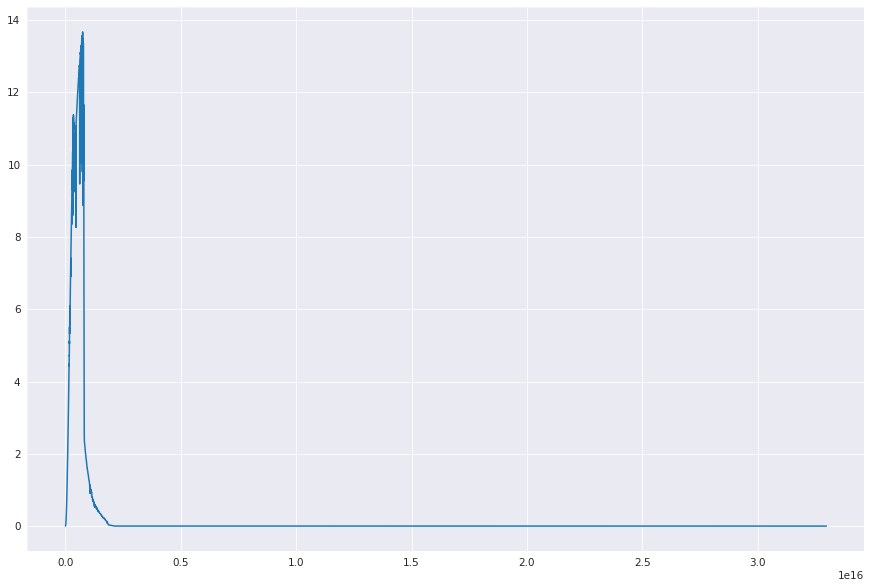

In [ ]:
plt.plot(model_sed['FREQUENCY'],model_sed['STELLAR_FLUX'])

## **Testing**

In [ ]:
df_star = df_M31[:1].copy()

In [ ]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000            #mJy

  df_star[f'{i}PSFFlux_err'] = (df_star[f'{i}PSFMagErr']*df_star[f'{i}PSFFlux'])/1.09  #mJy

In [ ]:
df_star

,Filter,RAJ2000,DEJ2000,ABmag,mag,Errmag,Field,M31Cat,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,Separation,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err
0,FUVCaF2,11.005,41.372601,22.556999,20.156,0.104,"b'1, 2 '",3,157640110050187706,11.005001,41.372588,20.251699,0.016611,20.385599,0.022176,20.485701,0.024243,20.354401,0.062501,20.3034,0.096491,0.369685,0.043593,0.028797,0.000439,0.025456,0.000518,0.023214,0.000516,0.026198,0.001502,0.027458,0.002431


In [ ]:
def chi2_func(Md,flux,model_flux,flux_err):
  chi = (flux - Md*model_flux)/flux_err
  return (chi**2).sum()

In [ ]:
# Convolved Filters
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)['TOTAL_FLUX'].value[:,0]
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)['TOTAL_FLUX'].value[:,0]

model_name = [ i  for i in Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)['MODEL_NAME']]

chi_set = []

# Chi2 loop : Takes about 5 minutes with current settings
for i,row in df_star.iterrows():

  flux     = row[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux']].values[0]
  flux_err = row[['gPSFFlux_err', 'rPSFFlux_err', 'iPSFFlux_err', 'zPSFFlux_err']].values[0]

  for j,model_flux in enumerate(zip(f1,f2,f3,f4)):
    model_flux = np.array(model_flux)
    Md         = minimize_scalar(chi2_func,args=(flux,model_flux,flux_err)).x
    chi2       = chi2_func(Md,flux,model_flux,flux_err)
    chi_set.append([row['objid'],model_name[j],Md,chi2])

In [ ]:
df_chi = pd.DataFrame(chi_set, columns = ['objid','model_name','Md','chi2'])

In [ ]:
df_chi_min = df_chi[0:0]
for i in df_chi['objid'].unique():
  df_temp = df_chi[ df_chi['objid'] == i]
  df_chi_min = df_chi_min.append(df_temp[df_temp['chi2']==df_temp['chi2'].min()])

In [ ]:
0.003362**2

1.1303044e-05

In [ ]:
df_chi_min

,objid,model_name,Md,chi2
1151,157640110050187706,kt06750g+1.5z-2.5,0.003362,5.204099


In [ ]:
len(df_chi_min.model_name.unique())

1

In [ ]:
f1 = Table.read('models_kurucz/convolved/PS1g.fits',hdu=1)
f2 = Table.read('models_kurucz/convolved/PS1r.fits',hdu=1)
f3 = Table.read('models_kurucz/convolved/PS1i.fits',hdu=1)
f4 = Table.read('models_kurucz/convolved/PS1z.fits',hdu=1)
f5 = Table.read('models_kurucz/convolved/PS1y.fits',hdu=1)

flux     = []
flux_err = []
for i,row in df_chi_min.iterrows():
  model_name = row['model_name']
  Md = row['Md'] 
  g = [f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f1[f1['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  r = [f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f2[f2['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  i = [f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f3[f3['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]
  z = [f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f4[f4['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  y = [f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX'].value[0][0] , f5[f5['MODEL_NAME'] == model_name]['TOTAL_FLUX_ERR'].value[0][0]]

  flux.append([ g[0], r[0], i[0], z[0], y[0]])
  flux_err.append([g[1], r[1], i[1], z[1], y[1]])

flux = np.array(flux)

In [ ]:
Md, flux 

(0.0033620263453063735,
 array([[8.47003588, 8.81700778, 8.51638143, 8.447642  , 8.10657498]]))

In [ ]:
tab_star                   = Table.from_pandas(df_star)
tab_star['model_flux']     =  flux
tab_star['model_flux_err'] =  flux_err
tab_star['model_mag']      =  -2.5*np.log10(tab_star['model_flux']/3631000)

In [ ]:
df_star[['gPSFFlux', 'rPSFFlux', 'iPSFFlux', 'zPSFFlux','yPSFFlux']].values, tab_star['model_flux'].value

(array([[0.02879695, 0.02545579, 0.02321379, 0.02619787, 0.02745783]]),
 array([[0.02847648, 0.02964301, 0.0286323 , 0.02840119, 0.02725452]]))

# **Color Matching**